In [2]:
from typing import Dict, List, Union
import os
import sys
import pytz
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator

from glob import glob
from collections import Counter
from datetime import datetime
from pathlib import Path

from vllm.tools.utils import parse_data, get_sys_name, get_short_system_name

DATAPATH = "../.artifact/benchmarks/results"
SAVEPATH = "./figure"

pd.set_option("display.max_columns", 500)

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
cmp = sns.color_palette("tab10")

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


def autolabel(rects, ax, prec=1):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.{prec}f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=16,
        )


def read_csv_with_concat(path="./csv", file_name=None):
    file = Path(path, f"{file_name}.csv")

    if file.exists():
        # If original file exists, read it directly
        df = pd.read_csv(file)
        print(f"Reading {file_name}")
    else:
        # If original file does not exist, read all the split files
        split_files = sorted(glob(f"{path}/{file_name}-2023-*.csv"))
        print(f"Reading splitted files: {split_files}")
        df = pd.concat([pd.read_csv(split_file) for split_file in split_files])
        df.reset_index(drop=True, inplace=True)
    return df


def calculate_sum_cdf_axis100(df, dot_num=1000):
    """
    Calculate quantity percentile CDF, y-axis: 0-100%,
    """
    print("Parsing")
    data = df.melt(id_vars="Time", var_name="Server")
    data.dropna(subset=["value"], inplace=True)
    # data.sort_values('value', ascending=True, inplace=True)
    # data.reset_index(drop=True, inplace=True)

    y = np.linspace(0, 1, num=dot_num)
    x = data["value"].quantile(y).values
    y = y * 100
    return x, y


def calculate_num_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str):
    """
    Calculate quantity percentile CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    data = df[[key]].copy()
    data.dropna(inplace=True)

    y = [len(data[data[key] <= x]) / len(data) * 100 for x in x_axis]

    return y


def calculate_sum_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str, key_to_time=None):
    """
    Calculate sum CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    if key_to_time is not None:
        data = df[[key, key_to_time]].copy()
        data["new"] = data[key] * data[key_to_time]
    else:
        data = df[[key]].copy()
        data["new"] = data[key]
    data.dropna(inplace=True)
    sum = data["new"].sum()

    y = [data[data[key] <= x]["new"].sum() / sum * 100 for x in x_axis]

    return y

#### Plot: Ablation Curve

In [3]:
data_path = f"{DATAPATH}/13b/pjlab"

distributions = [x for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
for dist in distributions:
    arrival_rates = [x for x in os.listdir(os.path.join(data_path, dist)) if os.path.isdir(os.path.join(data_path, dist, x))]
    for ar in arrival_rates:
        ar_str = ar.split("=")[1]
        files = [x for x in os.listdir(os.path.join(data_path, dist, ar)) if x.endswith(".jsonl")]
        df = pd.DataFrame()
        distribution = []
        for file in files:
            metadata, data = parse_data(os.path.join(data_path, dist, ar, file))
            distribution.append(metadata["distribution"])
            focus_group = [x for x in data if x["type"] in ["E2E Latency", "TTFT"]]
            filename = data_path.split("/")[-1].removesuffix(".jsonl")
            partial_df = pd.DataFrame(focus_group)
            partial_df["system"], partial_df["order"] = get_short_system_name(metadata)
            df = pd.concat([df, partial_df])
        distribution = list(set(distribution))
        assert len(distribution) == 1, "Multiple distributions found"
        distribution = distribution[0]
        # avg_latency = df.groupby(["system", "type"]).mean().reset_index()
        avg_latency = df.groupby(["system", "type"])["time"].mean().reset_index()

        # normalized latency to the baseline-1 system
        baseline_latency = avg_latency[avg_latency.system == "Baseline-1"]
        # divide the latency of each type by the baseline-1 latency
        avg_latency = pd.merge(avg_latency, baseline_latency, on="type", suffixes=("", "_baseline"))
        avg_latency["speedup"] = avg_latency["time_baseline"] / avg_latency["time"]
        # order by order
        avg_latency = avg_latency.sort_values(by="order")
        # for metric in ["E2E Latency", "TTFT"]:
        #     subdf = avg_latency[avg_latency.type == metric]
        #     # set line width
        #     fig = px.line(subdf, x="system", y="speedup", title="")
        #     fig.update_traces(line={"width": 6})
        #     set_plotly_theme(fig)
        #     fig.update_layout(margin=dict(t=50, l=20, r=10, b=15))
        #     set_font(fig)

        #     fig.update_yaxes(title_text="Speedup", tickfont=dict(size=36), title_font=dict(size=36))

        #     # set font size
        #     fig.update_xaxes(title_text="", tickfont=dict(size=36), title_font=dict(size=36))

KeyError: 'order'

In [14]:
df.groupby(["system", "type"])["time"].mean().reset_index()

,system,type,time
0,+Policy,E2E Latency,312.895922
1,+Policy,TTFT,22.400146
2,+Prefetch,E2E Latency,318.157467
3,+Prefetch,TTFT,78.588082


In [11]:
df

,id,model,time,type,system,order
0,0,delta-7,2.504113,E2E Latency,+Policy,3
1,0,delta-7,2.503311,TTFT,+Policy,3
2,1,delta-6,48.346892,E2E Latency,+Policy,3
3,1,delta-6,3.507167,TTFT,+Policy,3
4,2,/vllm/.idea/full_models/Llama-2-13b-hf,5.927483,E2E Latency,+Policy,3
...,...,...,...,...,...,...
733,366,delta-6,641.175231,TTFT,+Prefetch,2
734,367,delta-6,801.351264,E2E Latency,+Prefetch,2
735,367,delta-6,649.613817,TTFT,+Prefetch,2
736,368,delta-6,831.413687,E2E Latency,+Prefetch,2


In [9]:
distribution

'uniform'

#### CDF: GPU Job Duration & Utilization

In [12]:
x1 = [2**i for i in range(0, 22)]
y_gpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="duration")

# with open(f'{SAVEPKL}/util_gpu_util_mem_s.pkl', "rb") as file:
#     xx1, y1, x2, y2 = pickle.load(file)

with open(f"../cluster_util/plot_pkl_zm/util_gpu_s5.pkl", "rb") as file:
    # xx1, y1= pickle.load(file)
    xx1, y1, _, _, _, _, _, _, _, _ = pickle.load(file)

with open(f"{KALOSPKL}/util_gpu_util_mem_s.pkl", "rb") as file:
    x4, y4, x5, y5 = pickle.load(file)

with open(f"{SAVEPKL}/util_gpu_util_philly.pkl", "rb") as file:
    x3, y3 = pickle.load(file)

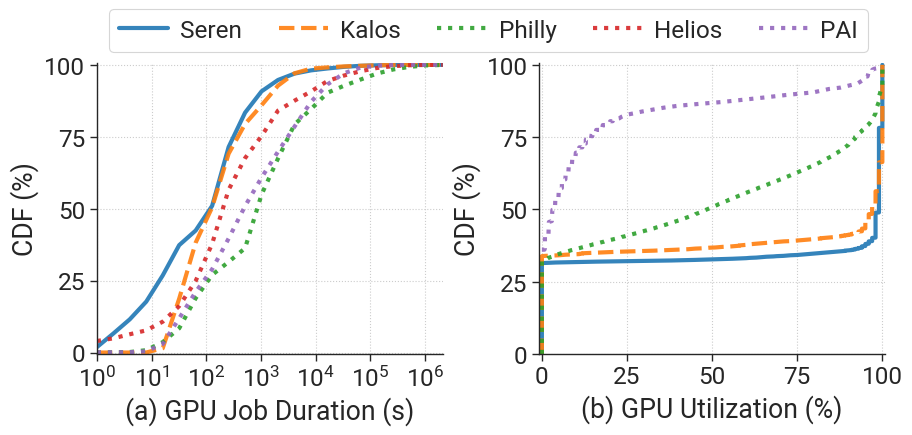

In [13]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

ax1.plot(x1, y_gpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x1, y_gpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.plot(x1, y_gpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax1.plot(x1, y_gpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax1.plot(x1, y_gpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax2.plot(xx1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax2.plot(x4, y4, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax2.plot(x3, y3, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")

# Add Antman, Philly Trace
df = pd.read_csv("../cluster_util/util_trace_antman_philly.csv")
ali_gutil = df.loc[:, ["ali_gpuutil_x", "ali_gpuutil_y"]].dropna()
ax2.plot(
    ali_gutil["ali_gpuutil_x"], ali_gutil["ali_gpuutil_y"], linestyles[2], label="PAI", linewidth=3, alpha=0.9, color=cmp[4]
)

ax1.set_xlabel(f"(a) GPU Job Duration (s)")
# ax1.set_ylabel(f"Fraction of Jobs (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xscale("log")
ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax1.set_xlim(1, x1[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
# ax1.legend(bbox_to_anchor=(0.51, 0.71))
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax2.set_xlabel(f"(b) GPU Utilization (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, 100.8)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncols=5, bbox_to_anchor=(0.1, 1.145), loc=2, columnspacing=1.5, handletextpad=0.5)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_job_duration_util.pdf", bbox_inches="tight")

#### Bar: Job Final State

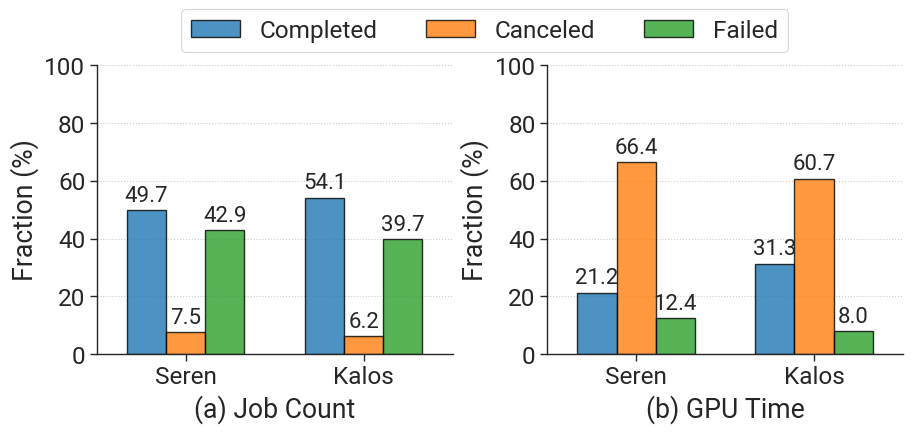

In [25]:
df = pd.read_csv("./csv/cluster_summary.csv", index_col="id")
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = np.arange(1, 3)
width = 0.22
p1 = ax1.bar(
    x - width,
    df.loc[["Seren", "Kalos"], "complete_rate_gpu"] * 100,
    width,
    label="Completed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)
p2 = ax1.bar(
    x, df.loc[["Seren", "Kalos"], "cancel_rate_gpu"] * 100, width, label="Canceled", alpha=0.8, linewidth=1, edgecolor="k"
)
p3 = ax1.bar(
    x + width, df.loc[["Seren", "Kalos"], "fail_rate_gpu"] * 100, width, label="Failed", alpha=0.8, linewidth=1, edgecolor="k"
)

p4 = ax2.bar(
    x - width,
    df.loc[["Seren", "Kalos"], "complete_rate_gpu_time"] * 100,
    width,
    label="Completed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)
p5 = ax2.bar(
    x, df.loc[["Seren", "Kalos"], "cancel_rate_gpu_time"] * 100, width, label="Canceled", alpha=0.8, linewidth=1, edgecolor="k"
)
p6 = ax2.bar(
    x + width,
    df.loc[["Seren", "Kalos"], "fail_rate_gpu_time"] * 100,
    width,
    label="Failed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)

autolabel(p1, ax1)
autolabel(p2, ax1)
autolabel(p3, ax1)
autolabel(p4, ax2)
autolabel(p5, ax2)
autolabel(p6, ax2)

ax1.set_xlabel(f"(a) Job Count")
ax1.set_ylabel(f"Fraction (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(["Seren", "Kalos"])
ax1.set_xlim(0.5, 2.5)
ax1.set_ylim(0, 100)
ax1.grid(axis="y", linestyle=":")

ax2.set_xlabel(f"(b) GPU Time")
ax2.set_ylabel(f"Fraction (%)")
ax2.set_xticks(x)
ax2.set_xticklabels(["Seren", "Kalos"])
ax2.set_xlim(0.5, 2.5)
ax2.set_ylim(0, 100)
ax2.grid(axis="y", linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    ncols=5,
    bbox_to_anchor=(0.18, 1.145),
    loc=2,
    #   columnspacing=1, handletextpad=0.2
)

sns.despine()
fig.savefig(f"{SAVEPATH}/bar_job_state.pdf", bbox_inches="tight")

#### Treemap: Job Number Distribution

In [185]:
print("Processing Seren")
data = data_s[data_s["gpu_num"] > 0]
data = data[~data["vc"].str.contains("3dobject")]
series = data["vc"].value_counts()
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]
gtime = data.groupby("vc")["gpu_time"].sum()

mllm_df = data[data["vc"].str.contains("mllm")]
sft_df = data[(data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam"))]
no_mllm = data[~(data["vc"].str.contains("mllm") | (data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam")))]

sft_df = pd.concat([sft_df, no_mllm[(no_mllm["jobname"].str.contains("sft", case=False))]])
no_mllm = no_mllm[~(no_mllm["jobname"].str.contains("sft", case=False))]

eval_df = no_mllm[
    (no_mllm["jobname"].str.contains("eval", case=False))
    | (no_mllm["jobname"].str.contains("infer", case=False))
    | (no_mllm["jobname"].str.contains("score", case=False))
    | (no_mllm["vc"].str.contains("eval", case=False))
]
no_eval = no_mllm[
    ~(
        (no_mllm["jobname"].str.contains("eval", case=False))
        | (no_mllm["jobname"].str.contains("infer", case=False))
        | (no_mllm["jobname"].str.contains("score", case=False))
        | (no_mllm["vc"].str.contains("eval", case=False))
    )
]

debug_df = no_eval[
    (no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False))
]
no_debug = no_eval[
    ~((no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False)))
]

pretrain_df = no_debug[no_debug["gpu_num"] > 32]
other_df = no_debug[no_debug["gpu_num"] <= 32]

data["type"] = None
data.loc[eval_df.index, "type"] = "Eval"
data.loc[debug_df.index, "type"] = "Debug"
data.loc[sft_df.index, "type"] = "Fine-tuning"
data.loc[pretrain_df.index, "type"] = "Pretrain"
data.loc[other_df.index, "type"] = "Other"
data.loc[mllm_df.index, "type"] = "MLLM"

# data.to_csv('./csv/s_trace_with_type.csv', index=None)

job_type = ["Evaluation", "Pretrain", "Fine-tuning", "MLLM", "Debug", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

df.at["Evaluation", "job_count"] = len(eval_df)
df.at["Fine-tuning", "job_count"] = len(sft_df)
df.at["Pretrain", "job_count"] = len(pretrain_df)
df.at["MLLM", "job_count"] = len(mllm_df)
df.at["Debug", "job_count"] = len(debug_df)
df.at["Other", "job_count"] = len(other_df)

df.at["Evaluation", "gtime"] = eval_df["gpu_time"].sum()
df.at["Fine-tuning", "gtime"] = sft_df["gpu_time"].sum()
df.at["Pretrain", "gtime"] = pretrain_df["gpu_time"].sum()
df.at["MLLM", "gtime"] = mllm_df["gpu_time"].sum()
df.at["Debug", "gtime"] = debug_df["gpu_time"].sum()
df.at["Other", "gtime"] = other_df["gpu_time"].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

df["label_percent"] = [f"{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime_percent"] = [f"{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]
df
df_s = df.copy()

Processing Seren


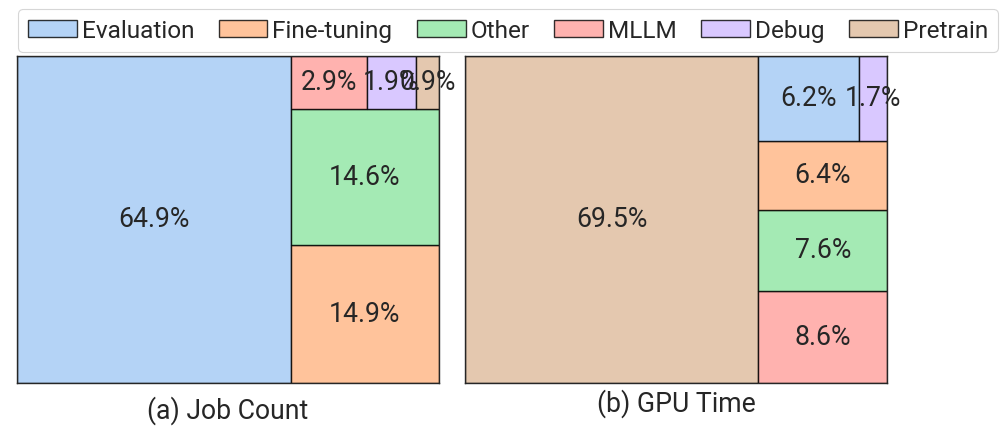

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
cmp_treemap = sns.color_palette("pastel")

df.sort_values(by="count_percent", ascending=False, inplace=True)
df["color"] = cmp_treemap[: len(df)]

squarify.plot(
    ax=ax1,
    sizes=list(df["job_count"].values),
    label=df["label_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles, labels=list(df.index), ncols=6, bbox_to_anchor=(0, 1.145), loc=2, columnspacing=1, handletextpad=0.2
)

df.sort_values(by="gtime", ascending=False, inplace=True)

squarify.plot(
    ax=ax2,
    sizes=list(df["gtime"].values),
    label=df["label_gtime_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# plt.axis('off')
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlabel(f"(a) Job Count")
ax2.set_xlabel(f"(b) GPU Time")

fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")

#### Box Plot: Request GPU number Different Type

In [4]:
print("NOTE: Only consider GPU Jobs here!  NOTE: According `type`")
data_seren = pd.read_csv("./csv/s_trace_with_type.csv")
data_kalos = pd.read_csv("./csv/ali_trace_with_type.csv")

NOTE: Only consider GPU Jobs here!  NOTE: According `type`


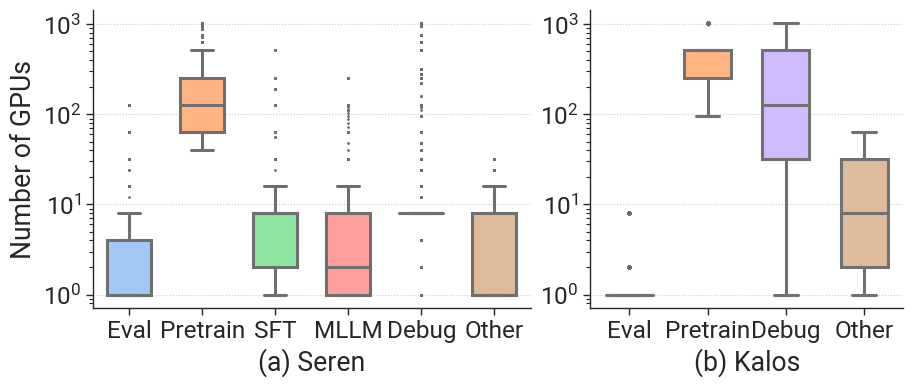

In [5]:
cmap = sns.color_palette("pastel")  #
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    gridspec_kw={"width_ratios": [4.2, 3]},
    constrained_layout=True,
    figsize=(9, 3.75),
)

############ Fig 1 ############
data_seren.sort_values(by="gpu_num", ascending=False, inplace=True)
data_seren["type"].replace("Fine-tuning", "SFT", inplace=True)
# data_seren['type'].replace("Debug", "DB", inplace=True)
# data_kalos['type'].replace("Debug", "DB", inplace=True)

x_ticks = [
    "Eval",
    "Pretrain",
    "SFT",
    "MLLM",
    "Debug",
    "Other",
]
# my_pal = {x_ticks[0]: cmp[1], x_ticks[1]: cmp[4], x_ticks[2]: cmp[2], x_ticks[3]: cmp[3], x_ticks[4]: cmp[0], x_ticks[5]: cmp[5]}
# my_pal = [cmp[1], cmp[4], cmp[5], cmp[3], cmp[0], cmp[2]]


flierprops = dict(marker=".", markerfacecolor="k", markersize=2, linestyle="none")
sns.boxplot(
    x="type",
    y="gpu_num",
    data=data_seren,
    flierprops=flierprops,
    width=0.6,
    linewidth=2.2,
    saturation=2,
    palette=cmap,
    ax=ax1,
    # fliersize=1,
    order=x_ticks,
    boxprops=dict(alpha=1),
)
sns.color_palette("tab10")
ax1.set_xlabel("(a) Seren")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel(f"Number of GPUs")
ax1.set_yscale("log")
# ax1.set_ylim(0, 900)
ax1.grid(axis="y", linestyle=":")


############ Fig 2 ############
data_kalos.sort_values(by="gpu_num", ascending=False, inplace=True)
data_kalos = data_kalos[data_kalos["type"] != "Fine-tuning"]
x_ticks_k = [
    "Eval",
    "Pretrain",
    "Debug",
    "Other",
]
# my_pal = {x_ticks_k[0]: cmp[1], x_ticks_k[1]: cmp[4], x_ticks_k[2]: cmp[2], x_ticks_k[3]: cmp[0], x_ticks_k[4]: cmp[5]}
my_pal = [cmap[0], cmap[1], cmap[4], cmap[5]]

flierprops = dict(marker=".", markerfacecolor="k", markersize=3, linestyle="none")
sns.boxplot(
    x="type",
    y="gpu_num",
    data=data_kalos,
    flierprops=flierprops,
    width=0.6,
    linewidth=2.2,
    saturation=2,
    palette=my_pal,
    ax=ax2,
    order=x_ticks_k,
    boxprops=dict(alpha=1),
)
sns.color_palette("tab10")
ax2.set_xlabel("(b) Kalos")
ax2.set_ylabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
# ax2.set_ylabel(f"Request GPU number")
ax2.set_yscale("log")
# ax1.set_ylim(0, 900)
ax2.grid(axis="y", linestyle=":")

# ax1.text(0.8, 0.9, "Seren", transform=ax1.transAxes, size=18,fontweight='bold')
# ax2.text(0.8, 0.9, "Kalos", transform=ax2.transAxes, size=18,fontweight='bold')
sns.despine()
fig.savefig(f"{SAVEPATH}/box_gpu_num.pdf", bbox_inches="tight")

#### Plot: Average Job submit number and request GPU number  (per hour)

In [76]:
from datetime import timedelta

# Process Seren data per hour
print("Processing Seren")
date_range = ("2023-03-01 00:00:00", "2023-08-17 23:50:00")
log = pd.read_csv(f"./csv/s_trace_with_type.csv", parse_dates=["submit_time", "start_time", "end_time"])
df = pd.DataFrame(
    pd.date_range(start=date_range[0], end=date_range[1], freq="10T"),
    columns=["time"],
)
df[
    [
        "submit_job_all",
        "start_job_all",
        "end_job_all",
        "submit_gpu_job",
        "start_gpu_job",
        "end_gpu_job",
        "submit_gpu_num",
        "start_gpu_num",
        "end_gpu_num",
    ]
] = 0
df["time"] = df.time.dt.tz_localize("UTC+08:00")
df.set_index("time", inplace=True, drop=True)

for i in range(len(df)):
    for kind in ("submit", "start", "end"):
        jobs = log[(log[kind + "_time"] >= df.index[i]) & (log[kind + "_time"] < df.index[i] + timedelta(minutes=10))]
        df[kind + "_job_all"][i] = len(jobs)
        df[kind + "_gpu_job"][i] = len(jobs[jobs["gpu_num"] != 0])
        df[kind + "_gpu_num"][i] = jobs["gpu_num"].agg(sum)

# Process Kalos data per hour
print("Processing Kalos")
date_range = ("2023-05-17 00:00:00", "2023-08-17 23:50:00")
log_k = pd.read_csv(f"./csv/ali_trace_with_type.csv", parse_dates=["submit_time", "start_time", "end_time"])
df_k = pd.DataFrame(
    pd.date_range(start=date_range[0], end=date_range[1], freq="10T"),
    columns=["time"],
)
df_k[
    [
        "submit_job_all",
        "start_job_all",
        "end_job_all",
        "submit_gpu_job",
        "start_gpu_job",
        "end_gpu_job",
        "submit_gpu_num",
        "start_gpu_num",
        "end_gpu_num",
    ]
] = 0
df_k["time"] = df_k.time.dt.tz_localize("UTC+08:00")
df_k.set_index("time", inplace=True, drop=True)

for i in range(len(df_k)):
    for kind in ("submit", "start", "end"):
        jobs = log_k[(log_k[kind + "_time"] >= df_k.index[i]) & (log_k[kind + "_time"] < df_k.index[i] + timedelta(minutes=10))]
        df_k[kind + "_job_all"][i] = len(jobs)
        df_k[kind + "_gpu_job"][i] = len(jobs[jobs["gpu_num"] != 0])
        df_k[kind + "_gpu_num"][i] = jobs["gpu_num"].agg(sum)

Processing Seren
Processing Kalos


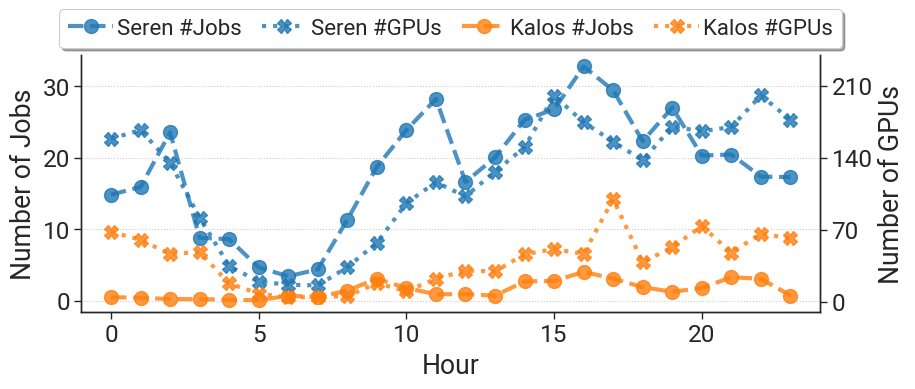

In [134]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))
linestyles = ["--o", ":X", "--o", ":X"]

############ Fig 1 ############
day_sub_mean, day_req_gpu = [], []
for i in range(0, 24):
    day_sub_mean.append(df[df.index.hour == i]["submit_gpu_job"].agg("mean"))
    day_req_gpu.append(df[df.index.hour == i]["submit_gpu_num"].agg("mean"))
k_day_sub_mean, k_day_req_gpu = [], []
for i in range(0, 24):
    k_day_sub_mean.append(df_k[df_k.index.hour == i]["submit_gpu_job"].agg("mean"))
    k_day_req_gpu.append(df_k[df_k.index.hour == i]["submit_gpu_num"].agg("mean"))

(A,) = ax1.plot(np.arange(0, 24), day_sub_mean, linestyles[0], alpha=0.8, label="Seren #Jobs", color=cmp[0])
(C,) = ax1.plot(np.arange(0, 24), k_day_sub_mean, linestyles[0], alpha=0.8, label="Kalos #Jobs", color=cmp[1])

ax1.set_xlabel(f"Hour")
# ax1.set_ylabel(f"Submitted #Jobs")
ax1.set_ylabel(f"Number of Jobs")
ax1.set_yticks(np.arange(0, 32, 10))
ax1.grid(axis="y", linestyle=":")
ax1.set_xlim(-1, 24)

ax2 = ax1.twinx()
(B,) = ax2.plot(np.arange(0, 24), day_req_gpu, linestyles[1], alpha=0.8, label="Seren #GPUs", color=cmp[0])
(D,) = ax2.plot(np.arange(0, 24), k_day_req_gpu, linestyles[1], alpha=0.8, label="Kalos #GPUs", color=cmp[1])

# ax2.set_ylabel(f"Requested #GPUs")
ax2.set_ylabel(f"Number of GPUs")
ax2.set_ylim(-10, 240)
ax2.set_yticks(np.arange(0, 240, 70))

lns = [A, B, C, D]
labs = [l.get_label() for l in lns]
ax1.legend(
    lns,
    labs,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.22),
    ncol=4,
    fancybox=True,
    shadow=True,
    fontsize=16,
    columnspacing=0.9,
    handletextpad=0.2,
)
sns.despine(left=False, top=True, right=False)
# ax1.text(0.01, 0.03, "Seren", transform=ax1.transAxes, size=16,fontweight='bold')
fig.savefig(f"{SAVEPATH}/plot_hour_submission.pdf", bbox_inches="tight")

#### CDF: Resource Utilization

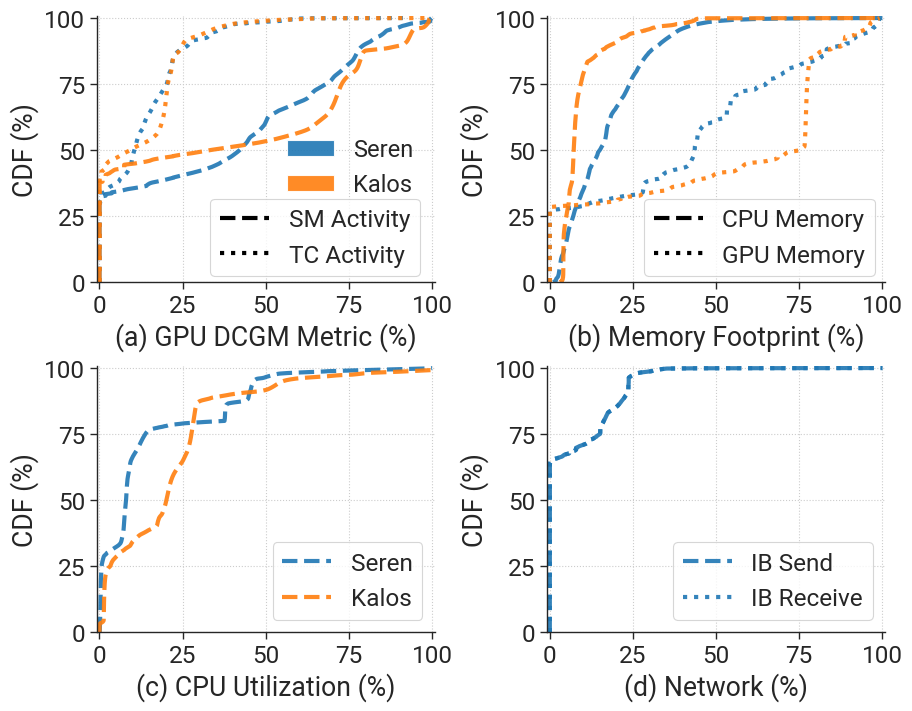

In [2]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
with open(f"{SAVEPKL}/util_gpu_s6.pkl", "rb") as file:
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = pickle.load(file)
# with open(f'{SAVEPKL}/util_gpu_k8.pkl', "rb") as file:
#     x1_k, y1_k, x2_k, y2_k, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"{SAVEPKL}/util_gpu_k8.pkl", "rb") as file:  # Use memory util only
    x1_k, y1_k, x2_k, y2_k, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"../cluster_util/plot_pkl_ali/util_gpu_ali_august_14_16.pkl", "rb") as file:  # Select 3 days with LLM
    x1_k, y1_k, _, _, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"../cluster_util/plot_pkl/util_cpu_mem_s.pkl", "rb") as file:
    x6, y6, x7, y7 = pickle.load(file)
with open(f"{SAVEPKL}/util_cpu_mem_k.pkl", "rb") as file:
    x6_k, y6_k, x7_k, y7_k = pickle.load(file)
with open(f"{SAVEPKL}/ib_cluster_s7.pkl", "rb") as file:
    x8, y8, x9, y9 = pickle.load(file)


x8 = x8 / x8.max() * 100
x9 = x9 / x9.max() * 100

linestyles = ["--", ":", "--", "-.", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(9, 7))

############ Fig 1: SM, Occupancy ############
ax1.plot(x3, y3, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren SM Activity")
ax1.plot(x5, y5, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren Occupancy")
ax1.plot(x3_k, y3_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos SM Activity")
ax1.plot(x5_k, y5_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos Occupancy")

############ Fig 2: CPU mem usage, GPU mem usage ############
ax2.plot(x7, y7, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren CPU Mem")
ax2.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Mem")
ax2.plot(x7_k, y7_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos CPU Mem")
ax2.plot(x2_k, y2_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Mem")

############ Fig 3: CPU util ############
ax3.plot(x6, y6, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax3.plot(x6_k, y6_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")

############ Fig 4: IB send, receive ############
ax4.plot(x8, y8, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="IB Send")
ax4.plot(x9, y9, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="IB Receive")

ax1.set_xlabel(f"(a) GPU DCGM Metric (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(-0.8, 100.8)
ax1.set_ylim(0, 100.8)
ax1.set_xticks([0, 25, 50, 75, 100])
# ax1.legend(loc="lower right")
ax1.grid(linestyle=":")

ax2.set_xlabel(f"(b) Memory Footprint (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, 100.8)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

ax3.set_xlabel(f"(c) CPU Utilization (%)")
ax3.set_ylabel(f"CDF (%)")
ax3.set_xlim(-0.8, 100.8)
ax3.set_xticks([0, 25, 50, 75, 100])
ax3.set_ylim(0, 100.8)
ax3.legend(loc="lower right")
ax3.grid(linestyle=":")

ax4.set_xlabel(f"(d) Network (%)")
ax4.set_ylabel(f"CDF (%)")
ax4.set_xlim(-0.8, 100.8)
ax4.set_xticks([0, 25, 50, 75, 100])
ax4.set_ylim(0, 100.8)
ax4.legend(loc="lower right")
ax4.grid(linestyle=":")
sns.despine()


S = mpatches.Patch(facecolor=cmp[0], alpha=0.9)  # , edgecolor="black"
K = mpatches.Patch(facecolor=cmp[1], alpha=0.9)
A = (Line2D([0], [0], color="black", lw=3, ls="--"),)
B = (Line2D([0], [0], color="black", lw=3, ls=":"),)

legend1 = ax1.legend([S, K], ["Seren", "Kalos"], bbox_to_anchor=(0.5, 0.62), loc=2, ncol=1, fontsize=17, frameon=False)

ax1.add_artist(legend1)

ax1.legend([A, B], ["SM Activity", "TC Activity"], bbox_to_anchor=(0.3, 0.36), loc=2, ncol=1)

ax2.legend([A, B], ["CPU Memory", "GPU Memory"], bbox_to_anchor=(0.25, 0.36), loc=2, ncol=1)

fig.savefig(f"{SAVEPATH}/cdf_resource_util.pdf", bbox_inches="tight")

#### CDF: Temperature

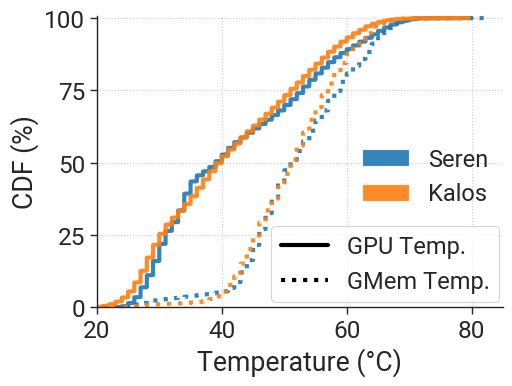

In [36]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
month_select = 8
with open(f"{SAVEPKL}/gpu_temp_s{str(month_select)}.pkl", "rb") as file:
    x1, y1, x2, y2 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_temp_k{str(month_select)}.pkl", "rb") as file:
    x1_k, y1_k, x2_k, y2_k = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_s{str(month_select)}.pkl", "rb") as file:
    x3, y3 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_k{str(month_select)}.pkl", "rb") as file:
    x3_k, y3_k = pickle.load(file)

linestyles = ["-", ":", ":", "-"]
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 3.75))

############ Fig 1: Temperature ############
ax1.plot(x1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Temp")
ax1.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Mem Temp")
ax1.plot(x1_k, y1_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Temp")
ax1.plot(x2_k, y2_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Mem Temp")

ax1.set_xlabel(f"Temperature (°C)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(20, 85)
ax1.set_ylim(0, 100.8)
# ax1.legend(
#     loc="lower right",
#     # bbox_to_anchor=(0.5, 1.4),
#     # ncol=2,
#     fancybox=False,
#     shadow=False,
#     fontsize=14)
ax1.grid(linestyle=":")

S = mpatches.Patch(facecolor=cmp[0], alpha=0.9)  # , edgecolor="black"
K = mpatches.Patch(facecolor=cmp[1], alpha=0.9)
A = (Line2D([0], [0], color="black", lw=3, ls="-"),)
B = (Line2D([0], [0], color="black", lw=3, ls=":"),)

legend1 = ax1.legend([S, K], ["Seren", "Kalos"], bbox_to_anchor=(0.6, 0.62), loc=2, ncol=1, fontsize=17, frameon=False)

ax1.add_artist(legend1)

ax1.legend(
    [A, B],
    ["GPU Temp.", "GMem Temp."],
    bbox_to_anchor=(0.4, 0.32),
    loc=2,
    ncol=1,
    fontsize=17,
)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_temperature.pdf", bbox_inches="tight")

#### CDF: Power

In [2]:
df_AB = pd.read_csv("../ipmi/csv/GPU_AB_Power.csv", parse_dates=["Time"])
df_C = pd.read_csv("../ipmi/csv/GPU_C_Power.csv", parse_dates=["Time"])
df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])

df_A = df_AB.dropna()
df_B = df_AB[df_AB.isna().any(axis=1)]  # Type B without MEM_Power record

dfs = {"GPU_A": df_A, "GPU_B": df_B, "GPU_C": df_C, "CPU_D": df_D}

# Extract sys_total_power
df_A_power = df_A[["Time", "Sys_Total_Power"]]
df_B_power = df_B[["Time", "Sys_Total_Power"]]
df_C_power = df_C[["Time", "Sys_Total_Power"]]
df_gpu = pd.concat([df_A_power, df_B_power, df_C_power])

x1, y1 = calculate_sum_cdf_axis100(df_gpu)
x2, y2 = calculate_sum_cdf_axis100(df_D[["Time", "Sys_Total_Power"]])

/tmp/ipykernel_221007/3576474441.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])


Parsing
Parsing


In [3]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
month_select = 8
with open(f"{SAVEPKL}/gpu_power_s5.pkl", "rb") as file:
    x3, y3 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_k{str(month_select)}.pkl", "rb") as file:
    x3_k, y3_k = pickle.load(file)

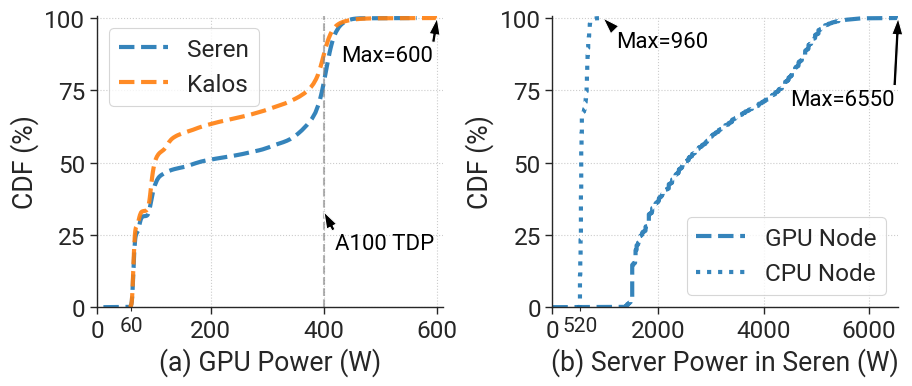

In [19]:
linestyles = ["--", ":", ":", "-"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

############ Fig 2: GPU power ############
ax1.plot(x3, y3, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x3_k, y3_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.axvline(x=400, ls="--", alpha=0.6, c="gray", ymax=100, lw=1.5)
ax1.annotate(
    "A100 TDP",
    xy=(400, 33),
    xytext=(420, 20),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
ax1.annotate(
    "Max=600",
    xy=(600, 100),
    xytext=(430, 85),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
# ax1.annotate('Max=564', xy=(564, 100), xytext = (400, 70), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=16)

############ Fig 1: CDF ############
ax2.plot(x1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="GPU Node")
ax2.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="CPU Node")
ax2.annotate(
    "Max=960",
    xy=(960, 100),
    xytext=(1200, 90),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
ax2.annotate(
    "Max=6550",
    xy=(6550, 100),
    xytext=(4500, 70),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)


ax1.set_xlabel(f"(a) GPU Power (W)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(-0.8, 610)
ax1.set_ylim(0, 100.8)
ax1.legend()
ax1.grid(linestyle=":")
ax1.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([60]))
ax1.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter([60]))
ax1.tick_params(axis="x", which="minor", labelsize=15)

ax2.set_xlabel(f"(b) Server Power in Seren (W)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, x1.max())
ax2.set_ylim(0, 100.8)
ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([520]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter([520]))
ax2.tick_params(axis="x", which="minor", labelsize=15)
sns.despine()

fig.savefig(f"{SAVEPATH}/cdf_power.pdf", bbox_inches="tight")

#### Bar: Mem Breakdown

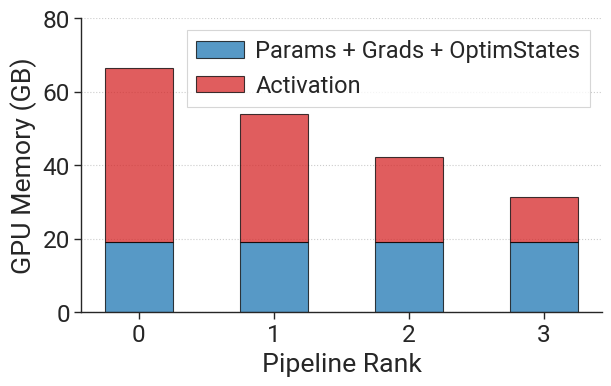

In [8]:
cmp = sns.color_palette("tab10")

fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3.75))
# x_labels = ['Rank0', 'Rank8', 'Rank16', 'Rank24', 'Rank32', 'Rank40', 'Rank48', 'Rank56']
x = np.arange(0, 4)

width = 0.5
# labels = ['Params','Grads', 'OptimStates','Activation']
activation = [56.19, 43.69, 31.9, 21.1]

# params = 8.81
# grads = 8.81
# os_params = 1.5

labels = ["Params + Grads + OptimStates", "Activation"]
other = 8.81 + 1.5 + 8.81
activation = [i - 8.81 for i in activation]

A = ax.bar(x, other, width, edgecolor="k", label="Params", alpha=0.75, color=[cmp[0]])
# B = ax.bar(x, grads, width, bottom=params, edgecolor="k", label='Grads', alpha=0.75, color = [cmp[1]])
# C = ax.bar(x, os_params, width, bottom=np.array(params) + np.array(grads), edgecolor="k", label='OS Params', alpha=0.75, color = [cmp[2]])
D = ax.bar(x, activation, width, bottom=np.array(other), edgecolor="k", label="Activation", alpha=0.75, color=[cmp[3]])

ax.set_ylabel("GPU Memory (GB)")
ax.set_ylim(0, 80)
# ax.set_title('GraphSAGE, N=4')
ax.set_xlabel(f"Pipeline Rank")
ax.set_xticks(x)
# ax.set_xticklabels(x_labels, fontsize=12)
ax.grid(axis="y", linestyle=":")


ax.legend(
    labels,
    # loc="upper center",
    # handles=labels,
    # bbox_to_anchor=(0.5, 1.22),
    ncol=1,
    fancybox=False,
    shadow=False,
    fontsize=17,
    columnspacing=1,
    handletextpad=0.5,
)

sns.despine()

fig.savefig(f"{SAVEPATH}/profiling_activation_pp.pdf", bbox_inches="tight")

#### Plot: Failure Workloads

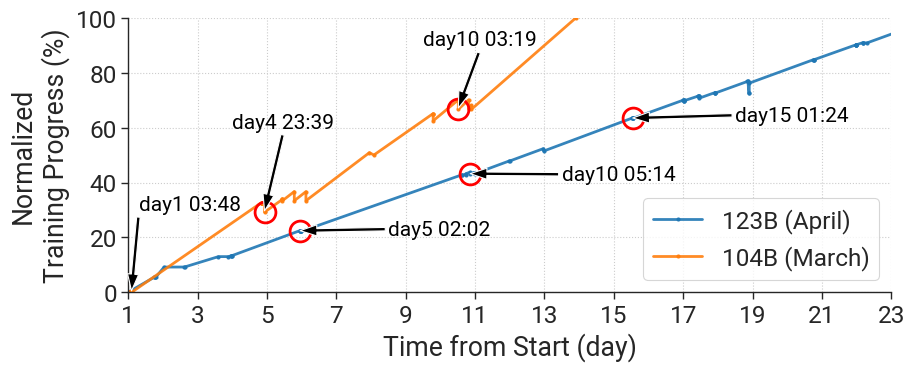

In [207]:
df1 = pd.read_csv(
    f"/mnt/petrelfs/share_data/wangzerui/llmtrace/llm_trace_collection/llm_job_logs/result/trace_of_each_job/630_v2.csv",
    index_col=False,
)[:49]
df2 = pd.read_csv(
    f"/mnt/petrelfs/share_data/wangzerui/llmtrace/llm_trace_collection/llm_job_logs/result/trace_of_each_job/1005.csv",
    index_col=False,
)[:60]

legend = []
dfs = [df1, df2]
# df.loc[df['start'] == 35.0, 'start'] = 2530
# df.loc[df['end'] == 35.0, 'end'] = 2200
for df in dfs:
    df["time_end"] = pd.to_datetime(df["time_end"])
    df["time_start"] = pd.to_datetime(df["time_start"])
import numpy as np


def get_xy(df):
    xs = []
    ys = []

    def merge_start_ends(job):
        xs.append(job["time_start"])
        xs.append(job["time_end"])
        ys.append(job["start"])
        ys.append(job["end"])

    df.apply(merge_start_ends, axis=1)
    xs_time = [item - xs[0] for item in xs]
    xs = [item.total_seconds() / 3600 for item in xs_time]
    max_y = max(ys)
    ys = [(item - ys[0]) / max_y for item in ys]
    # ys = [item * 100 for item in ys]
    return xs, ys


linestyles = ["-", "-", ":", "-"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.6))

max_x = 0

for idx, df in enumerate(dfs):
    xs, ys = get_xy(df)
    max_x = max(xs) if max(xs) > max_x else max_x
    ax1.plot(xs, ys, marker=".", markersize=4, linewidth=2, alpha=0.9, linestyle=linestyles[idx])

    # for id in ids:
    #     d = df.loc[df['id_job'] == 5894921]

ax1.set_xlabel(f"Time from Start (day)")
ax1.set_ylabel(f"Normalized\nTraining Progress (%)")
# plt.xticks(np.arange(0, max_x, 24))
ax1.set_xlim(0, 26)
ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels(np.arange(0, 110, 20))
ax1.legend(["123B (April)", "104B (March)"], loc="lower right")
ax1.grid(linestyle=":")
ax1.set_xticks(np.arange(0, max_x, 48))
# ax1.set_yticklabels(np.arange(0, 110, 20))
ax1.set_xticklabels([str(int(x) + 1) for x in np.arange(0, 24, 2)])


d1 = df.loc[df["id_job"] == 5894921]
x1, y1 = xs[d1.index[0] * 2 - 1], ys[d1.index[0] * 2 - 1]
d2 = df.loc[df["id_job"] == 5927199]
x2, y2 = xs[d2.index[0] * 2], ys[d2.index[0] * 2]
# # d3 = df.loc[df['id_job'] == 5928306]
# # x3, y3 = xs[d3.index[0]*2 - 1], ys[d3.index[0]*2 - 1]
d4 = df.loc[df["id_job"] == 5930311]
x4, y4 = xs[d4.index[0] + df.shape[0] + 1], ys[d4.index[0] + df.shape[0] + 1]

# ax1.plot(x1, y1, marker='o', mec='r', mfc='none')
ax1.plot(x2, y2, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
# # # ax1.plot(x3, y3, marker='o', mec='r', mfc='none')
ax1.plot(x4, y4, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day1 03:48",
    xy=(x1, y1 + 0.005),
    xytext=(0.3 * 24, 0.3),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
ax1.annotate(
    "day4 23:39",
    xy=(x2, y2 + 0.005),
    xytext=(3 * 24, 0.6),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# # # ax1.annotate('Day6, 00:13 AM', xy=(x3, y3), xytext = (x3-30, y3-1500), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=15)
ax1.annotate(
    "day10 03:19",
    xy=(x4, y4 + 0.005),
    xytext=(8.5 * 24, 0.9),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# # plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

ax1.plot(236.594722, 0.432318, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day10 05:14",
    xy=(236.5947220, 0.432318),
    xytext=(12.5 * 24, 0.41),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax2.plot

ax1.plot(118.930278, 0.224321, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day5 02:02",
    xy=(118.930278, 0.224321),
    xytext=(7.5 * 24, 0.21),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax2.plot

ax1.plot(349.086111, 0.635363, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day15 01:24",
    xy=(349.086111, 0.635363),
    xytext=(17.5 * 24, 0.625363),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax1.annotate()
# ax1.text(0.015, 0.03, "Seren", transform=ax1.transAxes, size=18,fontweight='bold')


sns.despine()
fig.savefig(f"{SAVEPATH}/failure_example.pdf", bbox_inches="tight")